In [1]:
%matplotlib inline
#
from lrgsglib import *
#
move_to_rootf(pathname='lrg_eegfc')
#
from lrg_eegfc import *
#
path_figs = Path('data') / 'figures' / 'test'
path_figs.mkdir(parents=True, exist_ok=True)

Current working directory: /home/opisthofulax/Documents/research+/brain_network/lrg_eegfc


### Data Reader

In [2]:
data_dict, int_label_pos_map = load_data_dict(
    mat_path, patients_list, phase_labels, param_keys_list
)

## Full pipeline protocol

In [3]:
ultraDist = {}

In [4]:
patient = 'Pat_02'
phase = 'rsPre'
if patient not in ultraDist.keys():
    ultraDist[patient] = {}
if phase not in ultraDist[patient].keys():
    ultraDist[patient][phase] = {}

In [5]:
correlation_protocol = dict(threshold=0, spectral_cleaning=True)
# Plot settings
kw_thline = dict(color='b', linestyle='--', label=r'$\mathcal{D}_{\rm th}$')
kw_draw_graph = dict(node_size=100, font_size=8, with_labels=False)
kw_dentro = dict(above_threshold_color='k', leaf_font_size=5, orientation='right')

In [6]:
data_pat = data_dict[patient]
pin_labels = int_label_pos_map[patient]['label']
data_pat_phase = data_pat[phase]
data_pat_phase_ts = data_pat_phase['data']
fs = data_pat_phase['fs']

### Correlation matrix computation
We use function `build_corrmat_single_band` to compute the correlation matrix of a timeseries $\bm{X}(t)$  after filtering on a specific brain band, which are reported in the table below.

| *BAND NAME*    | $\delta$   | $\theta$  | $\alpha$      | $\beta$      | $\gamma_{\rm l}$ | $\gamma_{\rm h}$ (HFO) |
| -------------- | ---------- | --------- | ------------- | ------------ | ---------------- | ---------------------- |
| *FREQUENCY*    | 0.53-4 Hz  | 4-8 Hz    | 8-13 Hz       | 13-30 Hz     | 30-80 Hz         | 80-300 Hz              |
| *BRAIN STATE1* | Sleep      | Intuition | Visualization | Alertness    | Insight          | Memory recall          |
| *BRAIN STATE2* | Healing    | Memory    | Relaxation    | Concetration | Synchronization  | Memory consolidation   |
| *BRAIN STATE3* | Deep aware | Meditate  | Creativity    | Cognition    | Peak attention   | Epileptic seizure      |

So after filtering the timeseries (for all the $N$ pins, of length $T$) with a band pass filter (Butterworth), we consider the timeseries per band $\bm{X}_{b}(t)$. From these we compute the correlation matrix C_b

perform a spectral cleaning using the Marchenko-Pastur distribution, cutting the eigenvalues that are indistinguishable from the gaussian process (ADD FORMULA)

In [7]:
# Build correlation matrices per band
corr_mat = build_corrmat_single_band(
    data_pat_phase_ts,
    fs,
    BRAIN_BANDS['delta'],
    jump_index=0,
    corr_network_params=correlation_protocol,
    filter_order=1
)

/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0034 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(


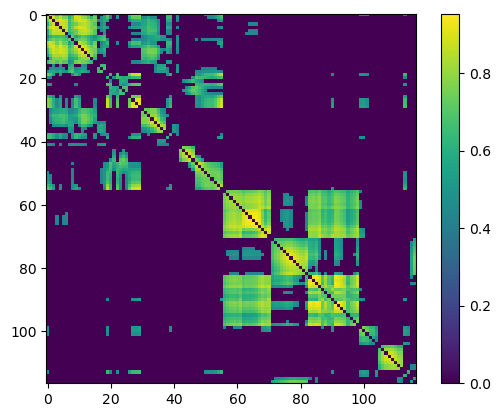

In [8]:
plt.imshow(corr_mat)
plt.colorbar()

In [23]:
all_bands_networks = {}
for band, (low_freq, high_freq) in BRAIN_BANDS.items():
    print(band, flush=True, end='\r')
    #
    result = process_network_for_phase(
        data_pat_phase_ts, fs, band, correlation_protocol, 
        pin_labels, filter_order=1
    )
    G, label_dict, lnkgM, clTh, corr_mat, dists = result
    # ultraDist[patient][phase][band] = extract_ultrametric_matrix(
    #     lnkgM,
    #     G.number_of_nodes()
    # )
    all_bands_networks[band] = {'G': G, 'linkage_matrix': lnkgM, 'clTh': clTh, 'corr_mat': corr_mat, 'dists': dists}

/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0034 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(


/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(


/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0049 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(


/tmp/ipykernel_13229/3618064133.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


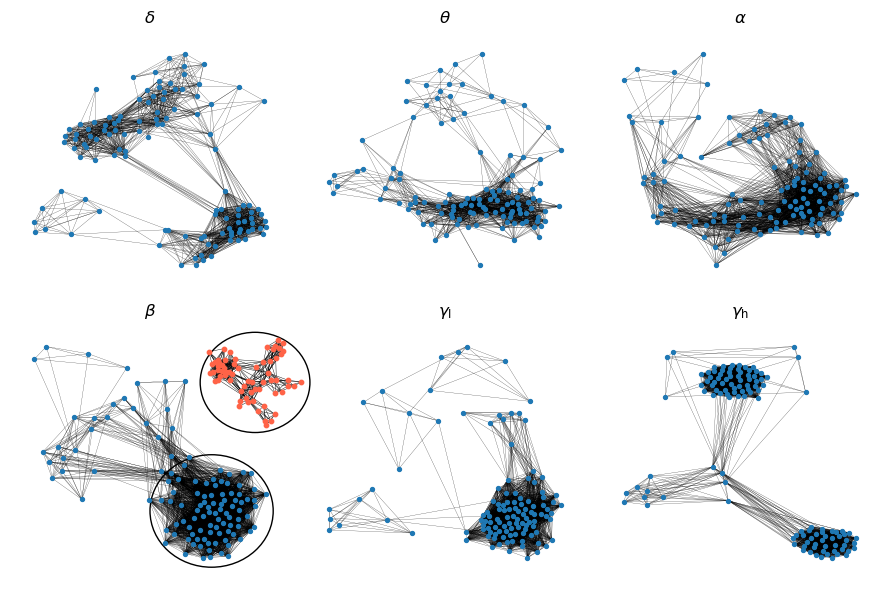

In [10]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

# adjustable threshold and target band
th = 0.71
target_band = 'beta'

n_bands = len(BRAIN_BANDS)
fig, axes = plt.subplots(2, (n_bands + 1) // 2, figsize=(3 * ((n_bands + 1) // 2), 6))
axes = axes.flatten()

for ax, (band, net_dict) in zip(axes, all_bands_networks.items()):
    G = net_dict['G']
    clTh = net_dict['clTh']

    # layout for main plot
    pos = nx.spring_layout(G, seed=43, scale=1, k=0.45)
    nx.draw(G, pos, ax=ax, width=0.15, node_size=8)
    ax.set_title(fr'{BRAIN_BANDS_LABELS[band]}')

    # add inset for the chosen band
    if band == target_band:
        # threshold edges
        edges_to_keep = [(u, v) for u, v, d in G.edges(data=True) if d.get('weight', 0) >= th]
        G_th = nx.Graph()
        G_th.add_nodes_from(G.nodes(data=True))
        G_th.add_edges_from(edges_to_keep)

        # extract giant component
        if G_th.number_of_edges() > 0:
            largest_cc = max(nx.connected_components(G_th), key=len)
            G_giant = G_th.subgraph(largest_cc).copy()
        else:
            G_giant = G_th

        # inset axis (like magnifying lens)
        ax_inset = inset_axes(ax, width="100%", height="100%", bbox_to_anchor=(.7,.6,.4,.4), bbox_transform=ax.transAxes)
        pos_giant = nx.spring_layout(G_giant, seed=42, scale=.1, k=.5)
        nx.draw(
            G_giant,
            pos_giant,
            ax=ax_inset,
            node_color='tomato',
            edge_color='k',
            node_size=10,
            width=.3
        )
        # ax_inset.set_title(f"Giant comp.\n(th={th:.2f})", fontsize=8)
        ax_inset.axis('off')
        import matplotlib.patches as mpatches

        circ_bg = mpatches.Circle(
            (0.5, 0.5), 0.49,
            transform=ax_inset.transAxes,
            facecolor=(1,1,1,.5), edgecolor='k',
            zorder=-1
        )
        ax_inset.add_patch(circ_bg)
        circ_bg = mpatches.Circle(
            (0.72, 0.27), 0.22,
            transform=ax.transAxes,
            facecolor=(1,1,1,.5), edgecolor='k',
            zorder=-1
        )
        ax.add_patch(circ_bg)
        # clip everything in the inset to the same circle
        ax_inset.set_clip_path(circ_bg)
        # # optional: draw connection lines between inset and main
        # mark_inset(ax, ax_inset, loc1=2, loc2=4, fc="none", ec="0.5", lw=0.8)

fig.tight_layout()
fig.savefig(path_figs / 'all_correlation_networks_with_inset.pdf')
plt.show()


In [148]:
def compute_partition_stability_index(linkage_matrix):
    """
    Compute the Partition Stability Index from a hierarchical clustering linkage matrix.
    
    Parameters
    ----------
    linkage_matrix : np.ndarray
        Linkage matrix from hierarchical clustering (N-1, 4) where N is number of nodes
        Column 2 contains the ultrametric distances (gaps) Delta_n
    
    Returns
    -------
    psi_values : np.ndarray
        Partition Stability Index values for each partition level
    n_communities : np.ndarray
        Number of communities corresponding to each PSI value
    """
    N = linkage_matrix.shape[0] + 1  # Number of original nodes
    
    # Extract ultrametric gaps (distances at each merge step)
    # linkage_matrix[:, 2] contains distances, sorted from smallest to largest
    deltas = linkage_matrix[:, 2]
    
    # Initialize arrays
    psi_values = []
    n_communities = []
    
    # Compute PSI for each partition level n
    # At step i, we have N-i communities (before merging to N-i-1)
    for i in range(len(deltas) - 1):
        n = N - i - 1  # Number of communities after this merge
        
        delta_n = deltas[i]      # Gap when going from n+1 to n communities
        delta_n_plus_1 = deltas[i + 1]  # Gap when going from n to n-1 communities
        
        # Avoid log(0) by adding small epsilon if needed
        if delta_n <= 0:
            delta_n = 1e-10
        if delta_n_plus_1 <= 0:
            delta_n_plus_1 = 1e-10
            
        # Compute Partition Stability Index
        psi = N * (np.log10(delta_n) - np.log10(delta_n_plus_1))
        
        psi_values.append(psi)
        n_communities.append(n)
    
    return -np.array(psi_values)/np.max(np.abs(psi_values)), np.array(n_communities)

/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/lrg/infocomm.py:150: RuntimeWarning: divide by zero encountered in log
  S[i] = -np.nansum(rho * np.log(rho)) / np.log(N)
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/lrg/infocomm.py:150: RuntimeWarning: invalid value encountered in multiply
  S[i] = -np.nansum(rho * np.log(rho)) / np.log(N)


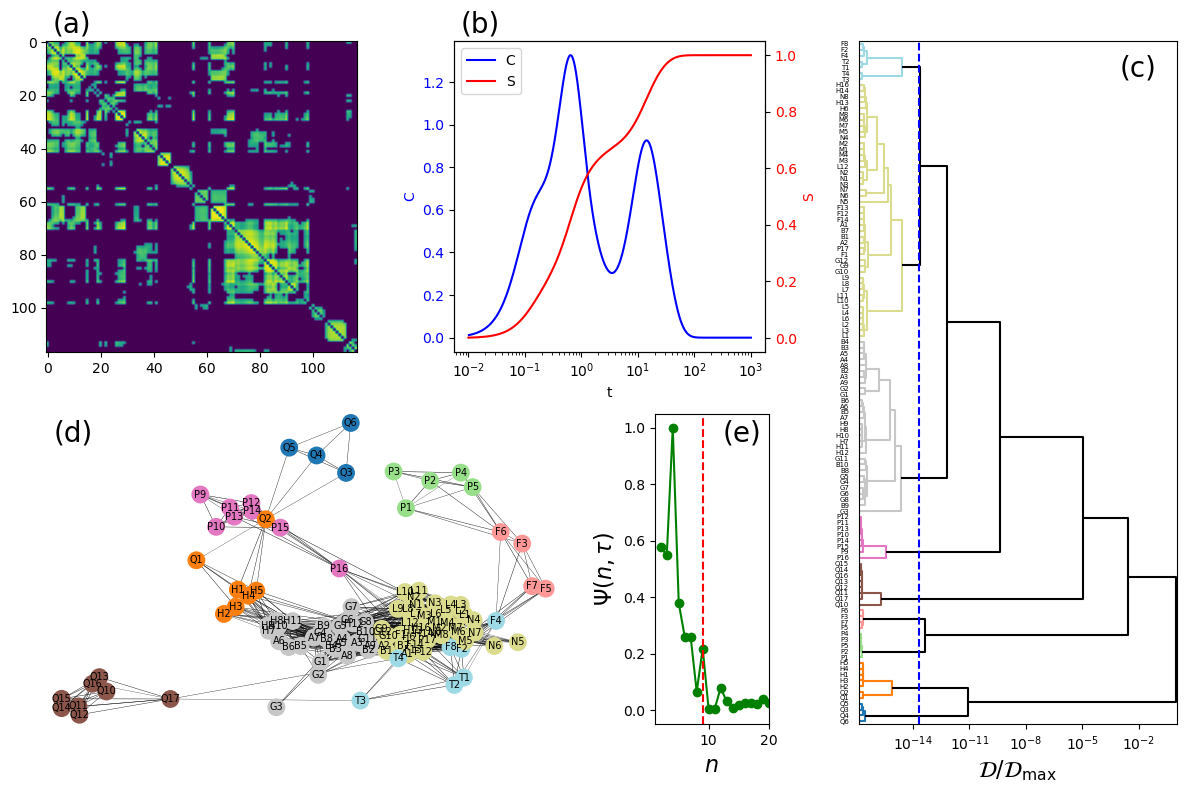

In [177]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Create custom grid layout: AABBCC / AABBCC / DDEECC / DDEECC
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(4, 6, figure=fig)

# Define subplot areas
ax_A = fig.add_subplot(gs[2:4, 0:3])  # rows 0-1, cols 0-1
ax_B = fig.add_subplot(gs[2:4, 3:4])  # rows 0-1, cols 2-3 --- IGNORE ---
ax_C = fig.add_subplot(gs[0:4, 4:6])  # rows 0-3, cols 4-5 (spans all 4 rows)
ax_D = fig.add_subplot(gs[0:2, 0:2])  # rows 2-3, cols 0-1
ax_E = fig.add_subplot(gs[0:2, 2:4])  # rows 2-3, cols 2-3

band = 'theta'

corr_m = all_bands_networks[band]['corr_mat']
G_tmp = all_bands_networks[band]['G']
lnkgM = all_bands_networks[band]['linkage_matrix']
clTh = all_bands_networks[band]['clTh']*.00005
sm1,dS,vL,ttts = entropy(G_tmp, t2=3)
pos = nx.spring_layout(G_tmp, seed=43, scale=1, k=0.27)


node_list = list(G.nodes())
labels_for_dendro = [label_dict[n] for n in node_list]
# Dendrogram first (to get the leaf colors)
# generate as many distinct colors as needed
n_colors = 9  # or more, depending on how many partitions you expect
palette = plt.cm.tab20(np.linspace(0, 1, n_colors))  # or 'hsv', 'nipy_spectral', etc.
palette = [plt.matplotlib.colors.to_hex(c) for c in palette]

hierarchy.set_link_color_palette(palette)


dendro = dendrogram(
    lnkgM,
    ax=ax_C,
    color_threshold=clTh,
    labels=labels_for_dendro,
    **kw_dentro
)
tmin = lnkgM[:, 2][0] * 0.8
tmax = lnkgM[:, 2][-1] * 1.01
ax_C.set_xscale('log')
ax_C.axvline(clTh, **kw_thline)
ax_C.set_xlim(tmin, tmax)
ax_C.set_xlabel(r'$\mathcal{D}/\mathcal{D}_{\max}$', fontsize=16)
# Get the leaf colors from dendrogram and map to nodes
leaf_label_colors = {lbl: col for lbl, col in zip(dendro['ivl'], dendro['leaves_color_list'])}
# Map node colors based on dendrogram leaf colors
node_colors = [leaf_label_colors.get(label_dict[n], 'gray') for n in node_list]
widths = [G[u][v]['weight'] for u, v in G.edges()]
wmin, wmax = min(widths), max(widths)
widths_scaled = [0.05 + .3 * (w - wmin) / (wmax - wmin) for w in widths]
nx.draw(G_tmp, pos, width=widths_scaled, ax=ax_A,  node_color=node_colors, node_size=140, with_labels=True, labels=pin_labels, font_size=7, font_color='k')
# nx.draw(G_tmp, pos, ax=ax_B, width=0.15, node_color=node_colors_new, node_size=50, with_labels=True, labels=pin_labels, font_size=5, font_color='white')

x, y = np.array(list(pos.values())).T
for axx in [ax_A]:
    axx.set_xlim(x.min() - 0.05, x.max() + 0.05)
    axx.set_ylim(y.min() - 0.05, y.max() + 0.05)
    # axx.set_aspect('equal')
    # axx.axis('on')

ax_D.imshow(corr_m)

# Create twin axes for the entropy plots
ax_E_twin = ax_E.twinx()

# Plot on left y-axis (ax_E)
line1 = ax_E.plot(ttts[1:], dS, '-', label='C', color='blue')
ax_E.set_ylabel('C', color='blue')
ax_E.tick_params(axis='y', labelcolor='blue')

# Plot on right y-axis (ax_E_twin)
line2 = ax_E_twin.plot(ttts, sm1, '-', label='S', color='red')
ax_E_twin.set_ylabel('S', color='red')
ax_E_twin.tick_params(axis='y', labelcolor='red')

# Set x-axis properties (shared between both)
ax_E.set_xscale('log')
ax_E.set_xlabel('t')
ax_E.set_box_aspect(1)


# Create combined legend
lines1, labels1 = ax_E.get_legend_handles_labels()
lines2, labels2 = ax_E_twin.get_legend_handles_labels()
ax_E_twin.legend(lines1 + lines2, labels1 + labels2, loc='best').set_zorder(200)

# Compute PSI for the current band's dendrogram
psi_values, n_communities = compute_partition_stability_index(lnkgM)

# Find the partition with maximum stability
max_psi_idx = np.argmax(-psi_values)
optimal_n_communities = n_communities[max_psi_idx]
max_psi_value = psi_values[max_psi_idx]

ax_B.plot(n_communities, psi_values, '-o', color='green')
ax_B.set_xlim(1,20)
ax_B.set_ylabel(r"$\Psi(n,\tau)$",fontsize=16)
ax_B.set_xlabel(r"$n$",fontsize=16)
ax_B.axvline(9, ls='--', c='r')

ax_A.text(0.02, 0.98, '(d)', transform=ax_A.transAxes, fontsize=20,  
          va='top', ha='left', )
ax_C.text(0.82, 0.98, '(c)', transform=ax_C.transAxes, fontsize=20,  
          va='top', ha='left', )
ax_D.text(0.02, 1.1, '(a)', transform=ax_D.transAxes, fontsize=20,  
          va='top', ha='left', )
ax_E.text(0.02, 1.1, '(b)', transform=ax_E.transAxes, fontsize=20,  
          va='top', ha='left', )
ax_B.text(.6, 0.98, '(e)', transform=ax_B.transAxes, fontsize=20,  
          va='top', ha='left', )

fig.tight_layout()
fig.savefig(path_figs / 'full analysis.pdf')